In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# NOTE: The following cells are for Google Colab only


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Dataset
PlantVillage dataset can be downloaded from Kaggle:
https://www.kaggle.com/datasets/emmarex/plantdisease


In [ ]:
!kaggle datasets download -d emmarex/plantdisease -p /content
!unzip -o /content/plantdisease.zip -d /content/dataset



Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: /content/dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: /content/dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: /content/dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: /content/dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: /content/dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
 

In [ ]:
!pip uninstall -y tensorflow keras keras-core keras-nightly tf-keras tensorflow-hub tensorflow-text tensorflow-decision-forests jax jaxlib ydf ml-dtypes protobuf flax orbax-checkpoint dopamine-rl keras-hub -q
!pip install tensorflow==2.18.0 numpy==1.26.4 matplotlib seaborn opencv-python-headless --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.79 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.


In [ ]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("Keras:", tf.keras.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.18.0
Keras: 3.12.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip uninstall -y keras keras-core keras-nightly tf-keras
!pip install -U tensorflow==2.18.0 numpy==1.26.4 --quiet


Found existing installation: keras 3.12.0
Uninstalling keras-3.12.0:
  Successfully uninstalled keras-3.12.0


In [ ]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("Keras:", tf.keras.__version__)


TensorFlow: 2.18.0
Keras: 3.12.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

print("TensorFlow:", tf.__version__)
print("MobileNetV2 imported successfully!")


TensorFlow: 2.18.0
MobileNetV2 imported successfully!


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os, matplotlib.pyplot as plt

DATA_DIR = '/content/dataset/PlantVillage'
BATCH_SIZE = 32
IMG_SIZE = (128,128)
EPOCHS = 10
FINE_TUNE_EPOCHS = 5
AUTOTUNE = tf.data.AUTOTUNE

# Split automatically (80/20)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset='training', seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset='validation', seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical'
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

train_ds = train_ds.map(lambda x,y: (preprocess_input(x), y)).cache().prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x,y: (preprocess_input(x), y)).cache().prefetch(AUTOTUNE)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Base Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))
base_model.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE,3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# Fine-tune last layers
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=FINE_TUNE_EPOCHS)

# Save model to Drive
MODEL_PATH = "models/trained_model_mobilenetv2.keras"
CLASS_NAMES_PATH = "models/class_names.json"
model.save(MODEL_PATH)
print('✅ Model saved to Drive successfully!')


Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.7407 - loss: 0.7914 - val_accuracy: 0.8357 - val_loss: 0.4885
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8326 - loss: 0.4985 - val_accuracy: 0.8641 - val_loss: 0.4135
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8551 - loss: 0.4302 - val_accuracy: 0.8553 - val_loss: 0.4315
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8674 - loss: 0.3903 - val_accuracy: 0.8721 - val_loss: 0.3811
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8746 - loss: 0.3673 - val_accuracy: 0.8827 - val_loss: 0.3419
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8775 - loss: 0.3518 - val_accuracy: 0.8788 - val_loss: 0.3553
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8837 - loss: 0.3408 - val_accuracy: 0.8931 - val_loss: 0.3222
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8898 - loss: 0.3246 - 

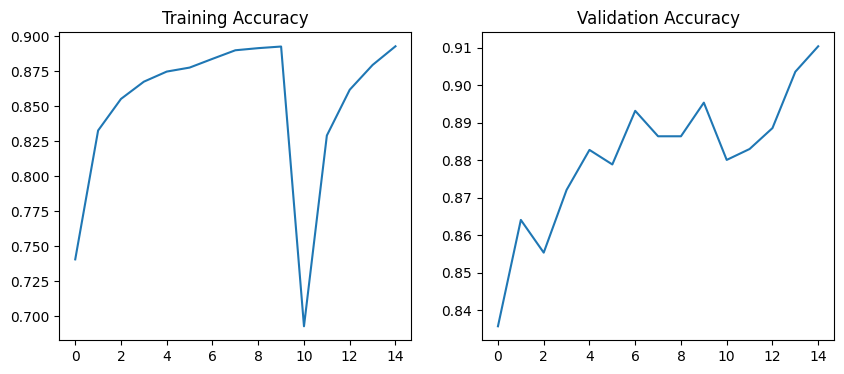

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.title('Training Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving bell_papper_unhealthy.jpeg to bell_papper_unhealthy.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


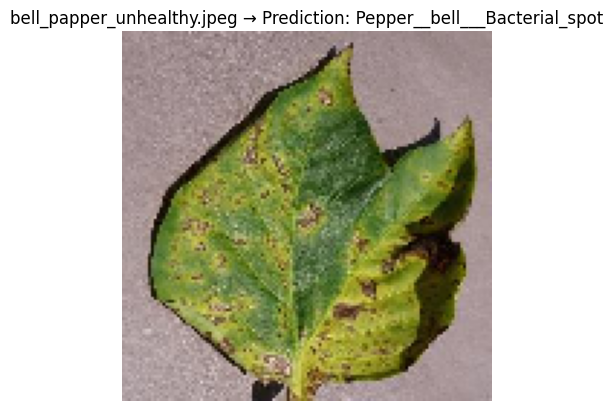

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

for fname in uploaded.keys():
    img_path = f'/content/{fname}'
    img = image.load_img(img_path, target_size=IMG_SIZE)
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = preprocess_input(arr)

    pred = model.predict(arr)
    idx = np.argmax(pred)

    # Display results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{fname} → Prediction: {class_names[idx]}")
    plt.show()



In [ ]:
import json
with open('/content/drive/MyDrive/class_names.json', 'w') as f:
    json.dump(class_names, f)
print('✅ Saved class names to Drive')


✅ Saved class names to Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# NOTE: The following cells are for Google Colab only


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install streamlit tensorflow pillow pyngrok --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 144.4 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image
import json

# NOTE:
# Download the trained model from Google Drive and place it in /models/
MODEL_PATH = "models/trained_model_mobilenetv2.keras"
CLASS_NAMES_PATH = "class_names.json"

# Load model and class names
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model(MODEL_PATH)
    return model

model = load_model()

with open(CLASS_NAMES_PATH, "r") as f:
    class_names = json.load(f)

IMG_SIZE = (128, 128)

st.title("🌿 Green Crop Analyzer")
st.write("Upload a leaf image to detect plant disease.")

uploaded_files = st.file_uploader("Upload leaf images", type=["jpg", "jpeg", "png"], accept_multiple_files=True)

if uploaded_files:
    for uploaded_file in uploaded_files:
        img = Image.open(uploaded_file)
        st.image(img, caption=f"Uploaded: {uploaded_file.name}", use_column_width=True)

        img = img.resize(IMG_SIZE)
        arr = image.img_to_array(img)
        arr = np.expand_dims(arr, axis=0)
        arr = preprocess_input(arr)

        pred = model.predict(arr)
        idx = np.argmax(pred)

        st.success(f"Prediction: **{class_names[idx]}**")


Writing app.py


In [ ]:
!ngrok config add-authtoken ("YOUR_SECRET_TOKEN")


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
!streamlit run app.py &>/content/logs.txt &
url = ngrok.connect(8501)
print("Your Web App URL:", url)


Your Web App URL: NgrokTunnel: "https://nonrepresentational-unexalting-simone.ngrok-free.dev" -> "http://localhost:8501"


In [ ]:
%%writefile .gitignore
# 🔐 Secrets
kaggle.json
*.env
ngrok.yml

# 🧠 Models
*.h5
*.keras
*.ckpt

# 📊 Dataset
dataset/

# 🐍 Python
__pycache__/
.ipynb_checkpoints/

Writing .gitignore
